In [45]:
import sys,os
import glob
import torch,dill
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from iresnet import iResBlock
from spectral_norm import SN
import torch.nn as nn
import torch.nn.functional as F
import scipy as sp
import numpy as np
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [8]:
paths = glob.glob(os.path.expanduser('~/tb-experiments/iresnet_inv_test_sfixed2/**/*.trainer'),recursive=True)
print(paths)

['/home/marc/tb-experiments/iresnet_inv_test_sfixed2/CIFAR10/iResnet/s0.5/trial0/checkpoints/c10.trainer']


In [9]:
trainer = torch.load(paths[-1],pickle_module=dill)
trainer.model.eval();

In [83]:
def eigh(mat):
    #print(mat.shape)
    return sp.linalg.eigh(mat,eigvals_only=True)

def singularValues(kernel,input_shape):
    transforms = np.fft.fft2(kernel,input_shape,axes=(0,1))
    return np.linalg.svd(transforms,compute_uv=False)
def singularValues2(kernel,input_shape):
    #print(kernel.shape)
    transforms = M= np.fft.fft2(kernel,input_shape,axes=(0,1))
    c = M.shape[-1]
    MtM = (M@M).reshape(-1,c,c)
    #print(MtM.shape)
    #eigh = lambda mat: sp.linalg.eigh(mat,eigvals=(c-1,c-1),eigvals_only=True)
    s = []
    for N in MtM:
        s.append(sp.linalg.eigh(N,eigvals=(c-1,c-1),eigvals_only=True))
    eigs = np.array(s)
    print(eigs.shape)
    return eigs
    #eigs = np.vectorize(eigh)(MtM)#np.apply_along_axis(eigh,0,MtM)
    print(eigs.shape)
#     A = np.real(transforms)
#     B = np.imag(transforms)
#     A_mB = np.concatenate((A,-B),axis=3).astype(np.float32)
#     B_A = np.concatenate((B,A),axis=3).astype(np.float32)
#     embedded_matrix = np.concatenate((A_mB,B_A),axis=2)
#     h,w,c2,_ = embedded_matrix.shape
#     M = torch.from_numpy(embedded_matrix.reshape(-1,c2,c2)).cuda()
#     M_t = M.permute((0,2,1))
#     MtM = torch.bmm(M_t,M)
    #print(embedded_matrix.shape)
    #return torch.svd(M,compute_uv=False).cpu().data.numpy()

In [101]:
def get_singular_values(trainer):
    h = 32
    channels = 32
    s = []
    for module in trainer.model[1].modules():
        if isinstance(module,SN):
            s_ = module._s
        if isinstance(module,nn.Conv2d):
            if module.weight.shape[0]>channels:
                h//=2
                channels = module.weight.shape[0]
            w = module.weight.cpu().data.clone()/torch.max(s_.cpu(),torch.tensor(1.))
    #         w2 = F.pad(w,(0,h-3,0,h-3))
    #         print(w2.shape)
            #w2_np  =w2.data.numpy()
            # 3 x 3 x c x c
            s.append(np.random.choice(singularValues(w.data.permute((2,3,0,1)).numpy(),(h//4,h//4)).reshape(-1),300))
    return s

Text(0, 0.5, 'Eigenvalues')

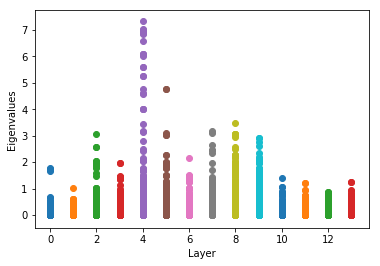

In [102]:
s = get_singular_values(trainer)
for i in range(len(s)):
    singulars = s[i].reshape(-1)
    plt.scatter(i*np.ones_like(singulars),singulars)
plt.xlabel("Layer")
plt.ylabel(r"Eigenvalues")

In [103]:
%lprun -f singularValues get_singular_values(trainer)

Timer unit: 1e-06 s

Total time: 0.22841 s
File: <ipython-input-83-baf59d13d4d7>
Function: singularValues at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def singularValues(kernel,input_shape):
     6        14      71233.0   5088.1     31.2      transforms = np.fft.fft2(kernel,input_shape,axes=(0,1))
     7        14     157177.0  11226.9     68.8      return np.linalg.svd(transforms,compute_uv=False)

In [23]:
np.im

AttributeError: module 'numpy' has no attribute 'im'